In [71]:
from google.colab import drive
drive.mount('/content/drive') # remove the cell if colab is not used

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path('/content/drive/MyDrive/data')

# Analiza i przetwarzanie danych na temat Titanica

#### Wyobraź sobie, że pewnego wakacyjnego dnia, będąc na plaży w pełnym słońcu, odbierasz telefon od nieznanego numeru.
Robisz to niechętnie — zasłużyłeś/aś przecież na odpoczynek i chcesz mieć ten czas tylko dla siebie. Już masz na końcu języka wymijającą odpowiedź, gdy nagle z drugiej strony słyszysz:
„Czy jesteś gotowy, by tego lata rozwikłać jedną z największych zagadek ludzkości?”

Jako osoba z natury ciekawa świata i ze świetnym umysłem analitycznym, szybko zapominasz o plaży i wakacjach. Zaintrygowany/a dopytujesz o szczegóły, ale rozmówca nie chce zdradzić zbyt wiele. Wiadomo jedynie, że chodzi o *zatonięcie Titanica w 1914* roku, a celem misji jest ustalenie, które osoby miały szansę przeżyć.

**Ty** — jako **renomowany analityk danych** — byłeś/byłaś ich pierwszym wyborem do analizy i oczyszczenia danych. Mimo wątpliwości postanawiasz podjąć się zadania, mając nadzieję, że twoja wiedza może zostać praktycznie wykorzystana w słusznym celu.

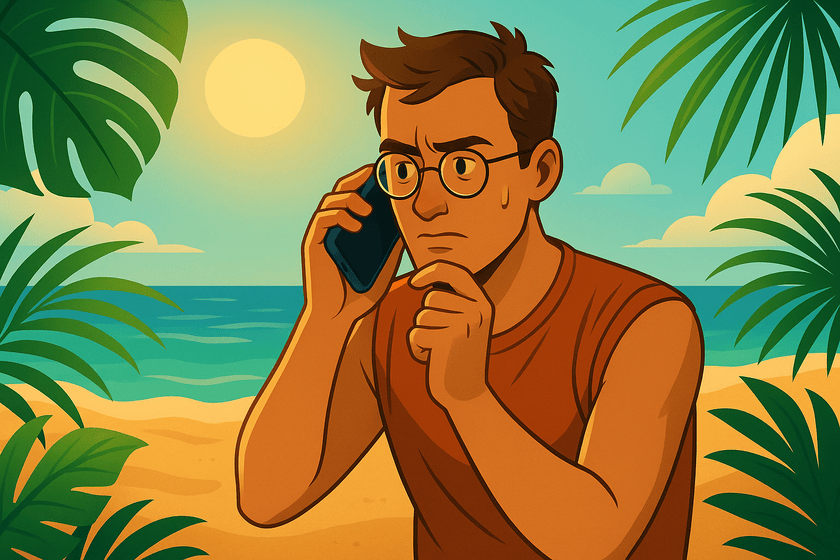

(*AI-generated image*)


#### Twoim celem będzie przeanalizowanie i przetworzenie zbioru danych w taki sposób, by mógł on być użyty do nauki modelu do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

(Uwaga: w tym zadaniu nie będziesz trenować modeli, ta przyjemność spotka cię w następnych notebookach)

Poniżej znajdziesz pytania, które mogą być pomocne w analizie, oraz odwołania do poszczególnych sekcji z notebooka do lekcji:

- Czy wszystkie kolumny są istotne w kontekście zadania?
- Czy występują brakujące wartości? Jeśli tak, to jak je uzupełnisz? (sekcja #2.1)
- Czy typy danych są odpowiednie do znaczenia kolumny? (sekcja #1.3)
- Czy dystrybucje danych mają rozkłady normalne, czy asymetryczne? (sekcja #4.1 + wykład)
- Która zmienna oznacza predykowaną klasę?
- Jaki jest rozkład zmiennej predykowanej względem zmiennych kategorialnych, jak i numerycznych? (sekcja #4.1)
- Czy końcowe rozkłady zawierają wartości skrajne? (sekcja #4.2 + wykład)

Wymagania:

- Zbiór musi być oczyszczony, tj. finalnie nie powinien mieć brakujących wartości (sekcja #2.1)
- Zbiór musi zawierać co najmniej dwie dodatkowe kolumny, które mogą wzbogacić informacje zawarte w zbiorze (sekcje #1.5 i #2.2)
- Cechy kategorialne powinny być zakodowane, postaraj się dobrać odpowiedni sposób (sekcja #2.3)
- Zbadaj, czy występują skrajne wartości (outliery) zarówno dla wartości numerycznych, jak i dla kategorialnych
- Każda cecha powinna być zwizualizowana co najmniej raz. Sam(a) zastanów się, czy warto wizualizować cechy parami w celu odkrycia zależności między nimi (sekcja #4.4)
- Nie ma ograniczenia na liczbę komórek, ale zastanów się, czy dana wizualizacja/obliczenie jest przydatne w całej analizie, czy po prostu sobie "egzystuje" bez żadnych wniosków

Zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Poniżej zamieszczamy tabelę z wyjaśnieniem poszczególnych kolumn:

| Kolumna      | Opis                                                                            |
| ------------ | ------------------------------------------------------------------------------- |
| **Survived** | Czy pasażer przeżył (0 = nie, 1 = tak).                                         |
| **Pclass**   | Klasa podróży (1 = I klasa, 2 = II klasa, 3 = III klasa).                       |
| **Name**     | Imię i nazwisko pasażera.                                                       |
| **Sex**      | Płeć pasażera (male = mężczyzna, female = kobieta).                             |
| **Age**      | Wiek pasażera w latach.                                                         |
| **SibSp**    | Liczba rodzeństwa i małżonków na pokładzie.                                     |
| **Parch**    | Liczba rodziców i dzieci na pokładzie.                                          |
| **Ticket**   | Numer biletu.                                                                   |
| **Fare**     | Cena biletu.                                                                    |
| **Cabin**    | Numer kabiny pasażera                                     |
| **Embarked** | Port, w którym pasażer wsiadł (C = Cherbourg, Q = Queenstown, S = Southampton). |
                                                         |


In [73]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

Czy wszystkie kolumny są istotne w kontekście zadania?
Neistotnymi kolumnami są Ticket i Name, więc możemy odazu się ich pozbawić

In [74]:
titanic_df = titanic_df.drop(['Name','Ticket'],axis=1)


Czy występują brakujące wartości? Jeśli tak, to jak je uzupełnisz?

Njapierw srpawdzimy ilość braków(w procentach), w jakich kolumnach są i czy można ich uzupełnić i w jaki sposób.

In [75]:
def get_percentage_missing(df, axis):
  missing_rows = df.isna().sum(axis=axis)
  missing_rows_perc = np.round(missing_rows / df.shape[axis] * 100, 2)
  return missing_rows_perc[missing_rows_perc > 0]

missing_cols_mi = get_percentage_missing(titanic_df, axis=0)
missing_cols_mi

,0
Age,19.87
Fare,11.00
Cabin,77.10
Embarked,0.22


Żeby zobaczyć w jaki sposób możemy uzupełnić istotne dane (Age,Fare) musimy zobaczyć rozkład - czy jest symetryczny/asymetryczny

Zrobimy wizualizacje danych dla łatwiejszej analizy

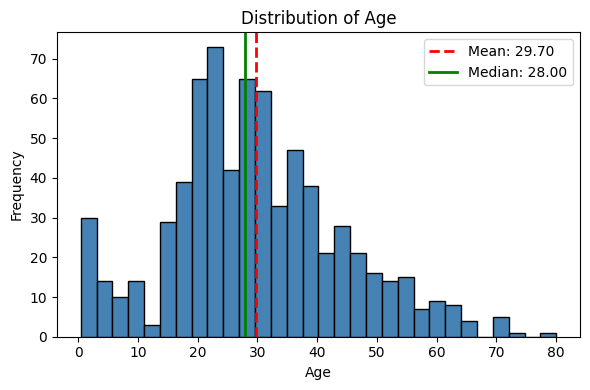

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numeric_histogram(df, column_name):

    data = df[column_name].dropna()
    mean_val = data.mean()
    median_val = data.median()

    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=30, color='steelblue', edgecolor='black')
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_numeric_histogram(titanic_df, 'Age')

Rozkład jest troche skośny prawostronnie, ale wartość srednia i mediana są blisko siebie.W tym przypadku liepszym rozwiązaniem będzie użycie mediany wieku opierając się na klase dla lepszego uzupełnienia danych.

In [77]:
age_median=titanic_df['Age'].median()
titanic_df['Age']=titanic_df['Age'].fillna(titanic_df.groupby('Pclass')['Age'].transform('median'))

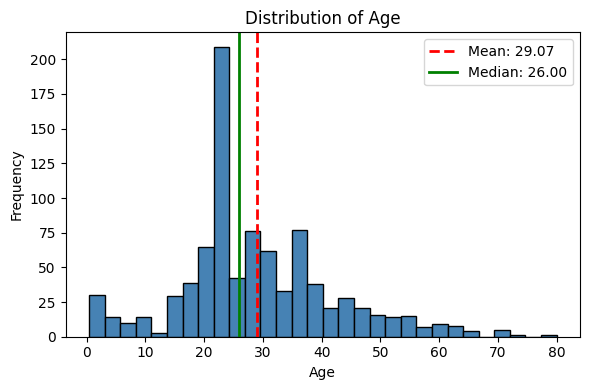

In [78]:
plot_numeric_histogram(titanic_df, 'Age')

Powyżej przedstawiony wykres już po uzupełnieniu danych.

Teraz zobaczymy rozkład Fare

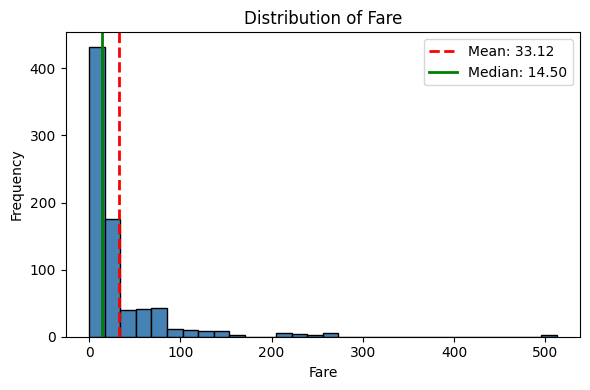

In [79]:
plot_numeric_histogram(titanic_df, 'Fare')

Wykres również jest skośny prawostronnie więc użyjemy mediany.

In [80]:
fare_median=titanic_df['Fare'].median()
titanic_df['Fare']=titanic_df['Fare'].fillna(fare_median)

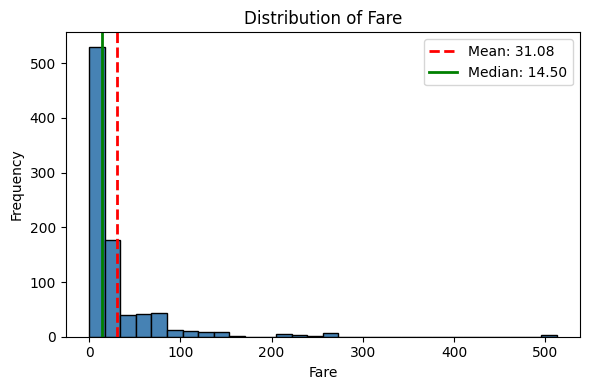

In [81]:
plot_numeric_histogram(titanic_df, 'Fare')

Wykres po uzupełnieniu danych.

Teraz możemy się zając uzupełnieniem danych Cabin - użyjemy innej metody i stworzymy oddzielna nową kategorie - unknown.
Również utworzymy nową kategorie według numerów kabin - sector w którym się znajdują opierając się na pierwszą litere w numerze kabiny.

In [82]:
titanic_df['Cabin']=titanic_df['Cabin'].fillna('Unknown')
titanic_df['Sector'] = titanic_df['Cabin'].str[0].fillna('Unknown')
titanic_df['Sector'].unique()
titanic_df.groupby('Pclass')[['Sector']].value_counts()

Pclass  Sector
1       C          59
        B          47
        U          40
        D          29
        E          25
        A          15
        T           1
2       U         168
        F           8
        D           4
        E           4
3       U         479
        F           5
        G           4
        E           3
Name: count, dtype: int64

W kodzie powyżej sprawdziłam czy litera w numerze cabiny jest związana z klasą, ale niestety nie ma żadnej korelacji więc nie dostajemy żadnych dodatkowych danych.Jednak może to miec korelacje z innymi danymi wiec zostawwimy to na pozniej.

Została nam kategoria Embarked do uzupełnienia. Dla uzupełnienia tych danych zobaczymy czy istnieje moda, której moglibyśmy użyc.

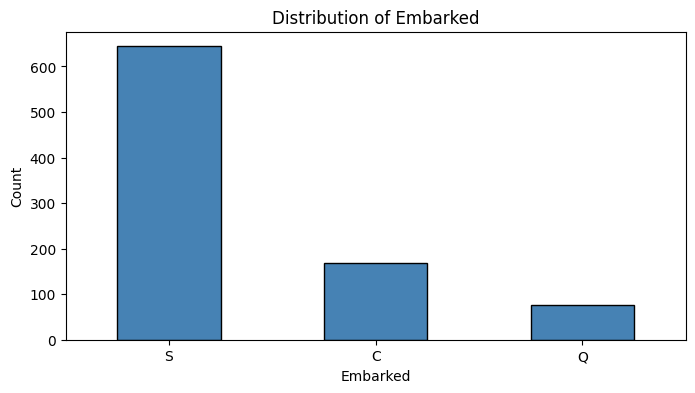

In [83]:
def plot_categorical_column(df, column_name):

    counts = df[column_name].value_counts()

    plt.figure(figsize=(8, 4))
    counts.plot(kind='bar', color='steelblue', edgecolor='black')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

plot_categorical_column(titanic_df,'Embarked')

Jest dobrze widoczna moda i ponieważ procent brakujących danych jest bardzo mały więc możemy z niej skorzystać dla uzupełnienia.

In [84]:
titanic_df['Embarked']=titanic_df['Embarked'].fillna('S')

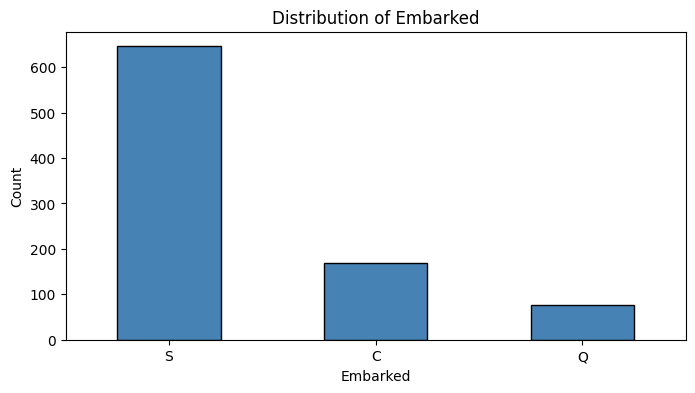

In [85]:
plot_categorical_column(titanic_df,'Embarked')

Czy typy danych są odpowiednie do znaczenia kolumny?

Zmieniamy typy na bardziej przyjazne dla python.

In [86]:
titanic_df = titanic_df.convert_dtypes()
titanic_df.dtypes

,0
Survived,Int64
Pclass,Int64
Sex,string[python]
Age,Float64
SibSp,Int64
Parch,Int64
Fare,Float64
Cabin,string[python]
Embarked,string[python]
Sector,string[python]


Czy dystrybucje danych mają rozkłady normalne, czy asymetryczne?

Wszystkie destrybucje danych numerycznych mają rozkłady asymetryczne skośne prawostronnie.Jedynie wykres wieku jest najbardziej przybliżony do rozkładu normalnego.

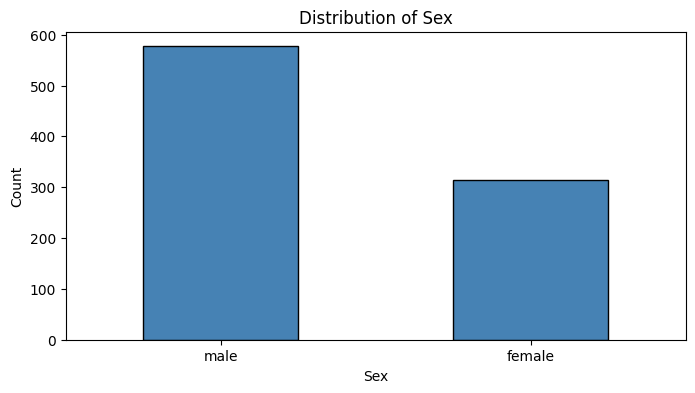

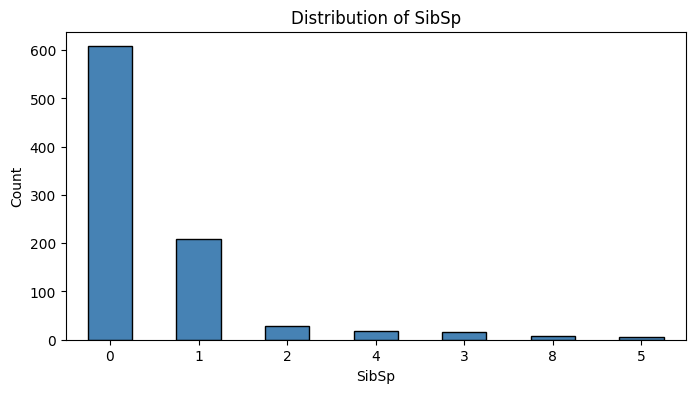

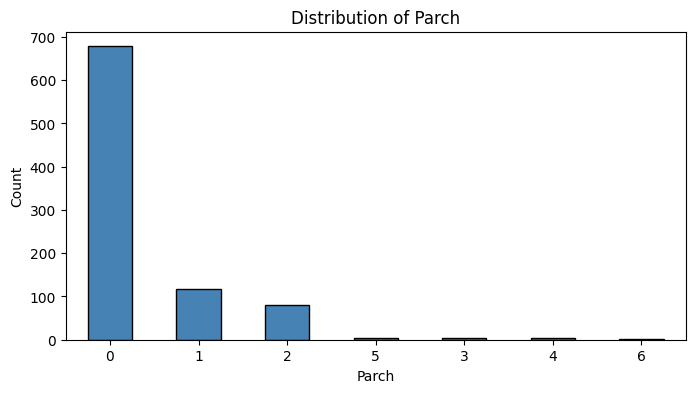

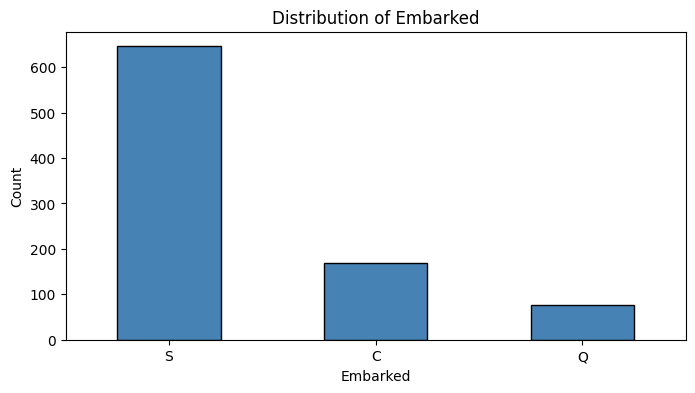

In [87]:
plot_categorical_column(titanic_df, 'Sex')
plot_categorical_column(titanic_df, 'SibSp')
plot_categorical_column(titanic_df, 'Parch')
plot_categorical_column(titanic_df, 'Embarked')

Która zmienna oznacza predykowaną klasę?
Predykowaną klasą w naszym wypadku jest klasa Survived

Zrobimy również nową kategorie Has_family w której polączymi dane o dzieciach/rodzicach i parach/rodzenstwach dla uproszczenia pozniejszej analizy.
Poniżej są wypisane osoby których pózniej połącze w jedną kategorie (w tym samotna matka z 5 dziećmi)

In [88]:
has_parch = titanic_df.Parch == 0
has_sib = titanic_df.SibSp == 0
titanic_df.loc[~has_parch | ~has_sib]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Sector
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.25,Unknown,S,U
2,1,1,female,38.0,1,0,71.2833,C85,C,C
4,1,1,female,35.0,1,0,53.1,C123,S,C
8,0,3,male,2.0,3,1,21.075,Unknown,S,U
9,1,3,female,27.0,0,2,14.5,Unknown,S,U
...,...,...,...,...,...,...,...,...,...,...
875,1,2,female,28.0,1,0,24.0,Unknown,C,U
880,1,1,female,56.0,0,1,83.1583,C50,C,C
881,1,2,female,25.0,0,1,26.0,Unknown,S,U


In [89]:
titanic_df['HasFamily'] = titanic_df.apply(lambda x: 1 if x['SibSp'] > 0 or x['Parch'] > 0 else 0, axis=1)

Jaki jest rozkład zmiennej predykowanej względem zmiennych kategorialnych, jak i numerycznych?


Zrobimy hetmap dla lepszej wizualizacji korelacji między danymi. Żeby dało się to zrobić musimy przerobić wszystkie potrzebne dane na dane numeryczne.

In [90]:
titanic_df['Sex'] = titanic_df['Sex'].map({'male': 0, 'female': 1})
titanic_df['Embarked'] = titanic_df['Embarked'].map({'C': 0, 'S': 1, 'Q': 2})
titanic_df['Sector'] = titanic_df['Sector'].map({
    'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8,'U': 0
})


In [91]:
def plot_correlation_matrix(df):
    # compute correlation matrix only for numeric columns
    corr = df.corr(numeric_only=True)

    # fmt=".2f" rounds the number to 0.01
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

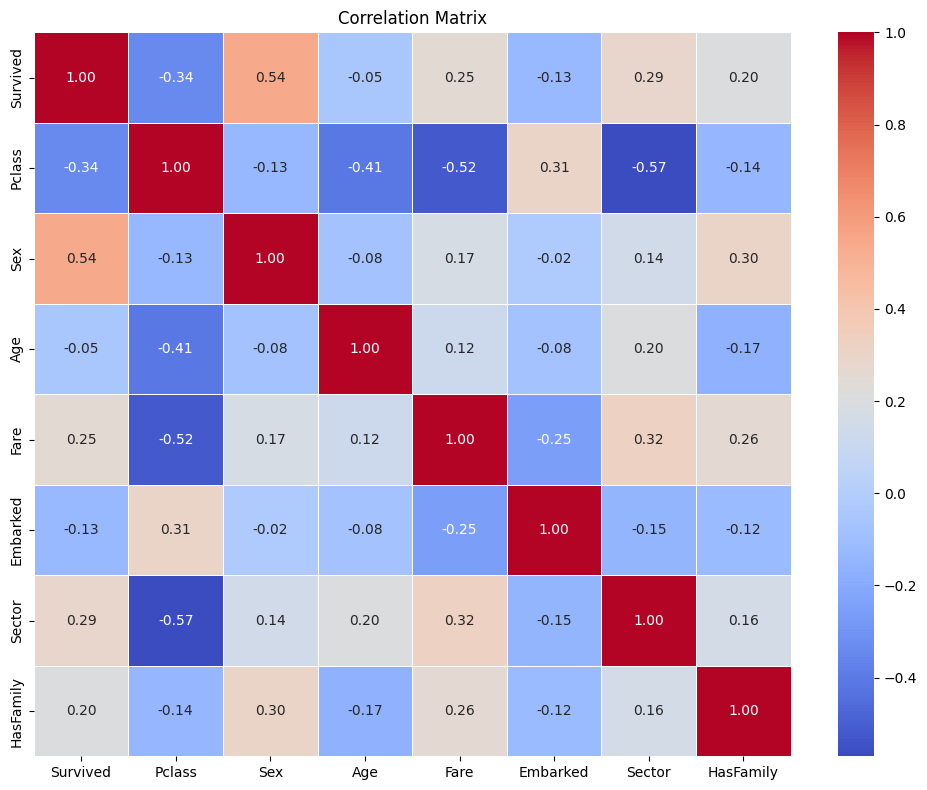

In [92]:
titanic_df_backup = titanic_df.copy()
titanic_df_backup = titanic_df_backup.drop(['Parch','SibSp'],axis=1)
plot_correlation_matrix(titanic_df_backup)

Na wykresie powyzej widać że najwieksza korelacja czy osoba przetrwała jest od płci i klasy.Wbrew moim oczekiwaniom, wiek ma najmniejszy wpływ na to, czy osoba przetrwala.Pózniej to wyjaśnimy.


In [93]:
titanic_df.groupby(['Sector','Pclass'])['Survived'].mean()

Sector  Pclass
0       1            0.475
        2         0.440476
        3         0.235908
1       1         0.466667
2       1         0.744681
3       1          0.59322
4       1         0.758621
        2             0.75
5       1             0.72
        2             0.75
        3              1.0
6       2            0.875
        3              0.2
7       3              0.5
8       1              0.0
Name: Survived, dtype: Float64

W tablicy powyżej szukałam związku między klasa, typem kabiny a przetrwaniem, lecz niestety przez duże braki danych ustalenie zależnośći jest dość cieżkie.

In [94]:
def mean_by_category(df, group_by_column, value_column):

    mean_values = df.groupby([group_by_column])[value_column].mean()

    plt.figure(figsize=(8, 6))
    mean_values.plot(kind='bar', color='thistle', edgecolor='black')

    plt.title(f'Średnia {value_column} w zależności od {group_by_column}')
    plt.xlabel(group_by_column)
    plt.ylabel(f'Średnia {value_column}')
    plt.xticks(rotation=0)
    plt.show()

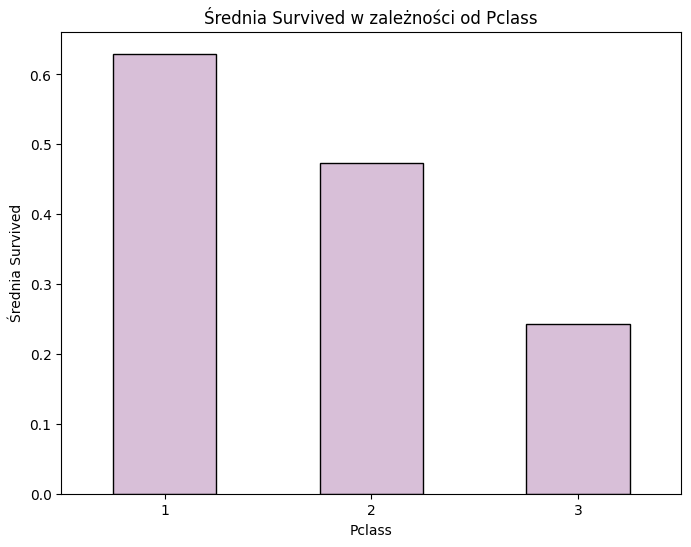

In [95]:
mean_by_category(titanic_df, 'Pclass', 'Survived')

Jak i było widac na heatmap, najmocniejszą korelacją z przetrwaniem była klasa.

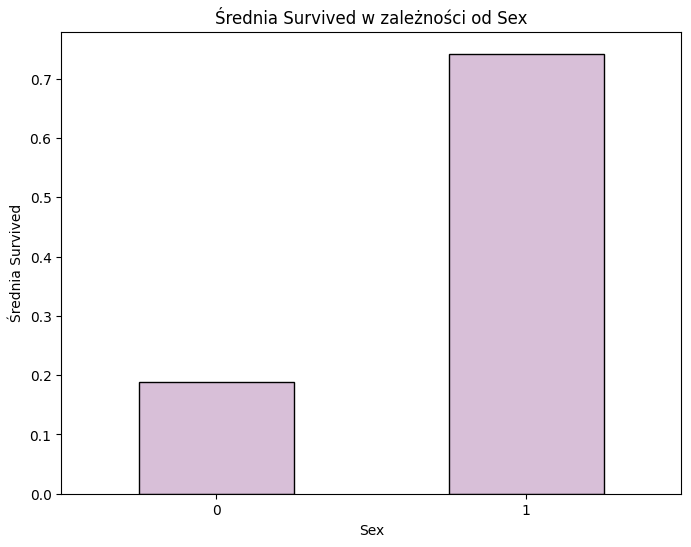

In [96]:
mean_by_category(titanic_df, 'Sex', 'Survived')

Drugim parametrem po klasie była płec osoby.O wiele większy procent kobiet przetrwał.Kobiet ogolnie bylo mniej niz mężczyzn, ale o wiele wiecej z nich przetrwalo.


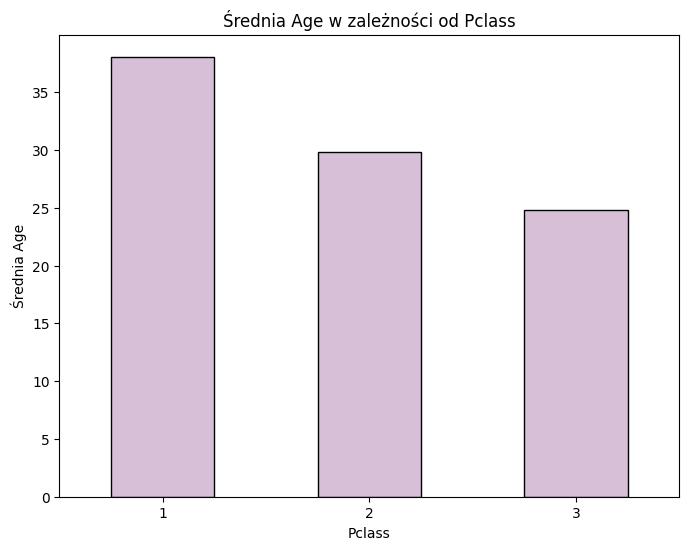

In [97]:
mean_by_category(titanic_df, 'Pclass', 'Age')

Na tym wykresie jest mocno widoczne że im lepsza klasa tym są starsze w niej osoby, co właśnie mocno zwiększa szanse starszych osob na przetrwanie i powoduje niska korelacje z wiekiem uratowanych osob.

Jak się można domysleć patrząc na korelacje klasy a przetrwania, cena za bilet ma mocny wpływ czy osoba zostanie uratowana.

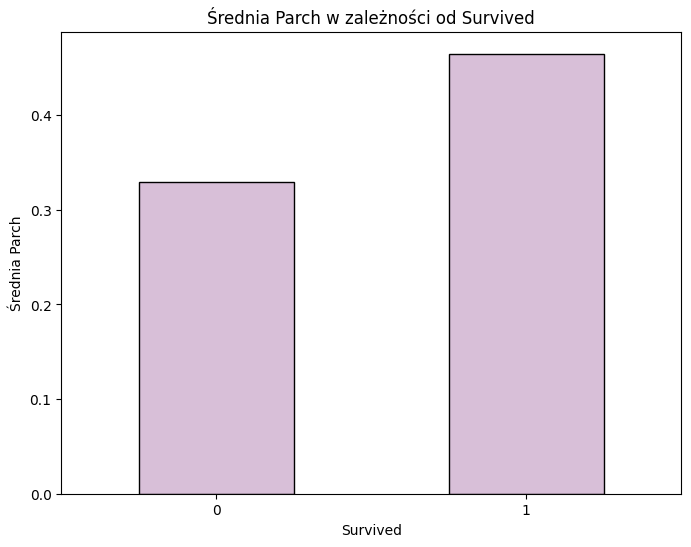

In [98]:
mean_by_category(titanic_df, 'Survived', 'Parch')

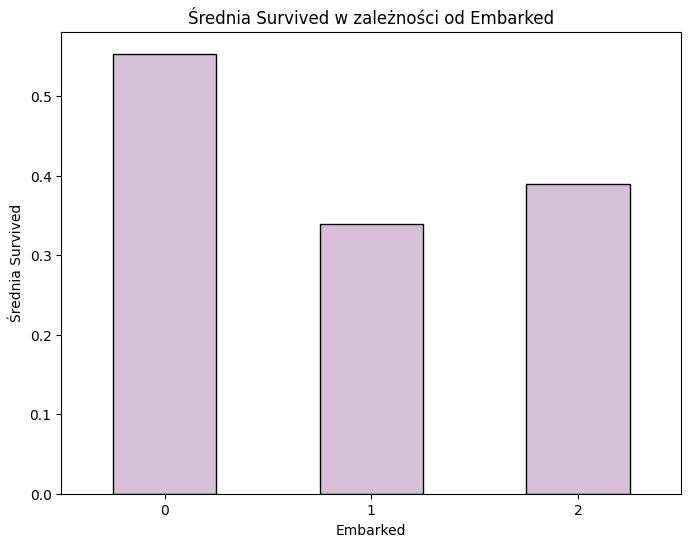

In [99]:
mean_by_category(titanic_df, 'Embarked', 'Survived')

Najwięcej osób co wsiedli Cherbourg przeżyli.

Więcej osob z rodziną przetrwało.Pózniej zobaczymy bardziej szczególnie, czy ta reguła działa tak samo dla różnych płci.

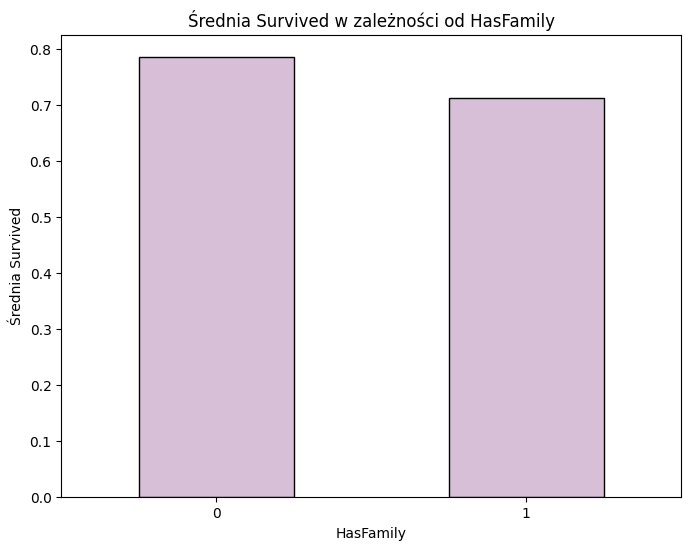

In [100]:
titanic_df_copy = titanic_df.copy()
titanic_df_copy = titanic_df_copy[titanic_df_copy['Sex'] == 1].copy()
mean_by_category(titanic_df_copy, 'HasFamily', 'Survived')

Więcej kobiet bez dzieci przetrwało niż kobiet z rodziną lub dziećmi, lecz różnica jest dość mała.

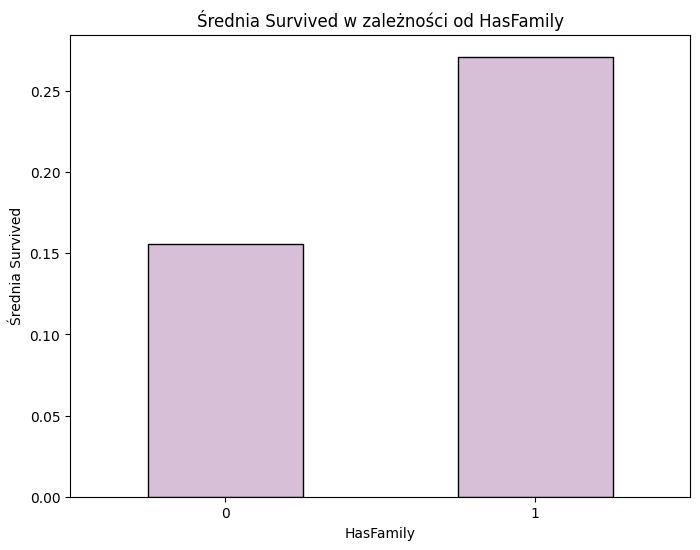

In [101]:
titanic_df_copy = titanic_df.copy()
titanic_df_copy = titanic_df_copy[titanic_df_copy['Sex'] == 0].copy()
mean_by_category(titanic_df_copy, 'HasFamily', 'Survived')

W odróżnieniu od kobiet o wielie więcej mężczyzn posiadających rodzine przetrwało. Jest to dosyc logiczne, ponieważ w pierwszej kolejności ratowano kobiet z dziećmi i ich mężowie/ojcowie również byli ratowani jako pierwsi wsród facetów.


Czy końcowe rozkłady zawierają wartości skrajne?
Sprawdzimy.

In [102]:
def grouped_boxplot(df, category_column, value_column):

    plt.figure(figsize=(8, 6))
    sns.boxplot(x=category_column, y=value_column, data=df)
    plt.title(f'Rozkład {value_column} w zależności od {category_column}', fontsize=16)
    plt.xlabel(category_column, fontsize=12)
    plt.ylabel(value_column, fontsize=12)
    plt.show()

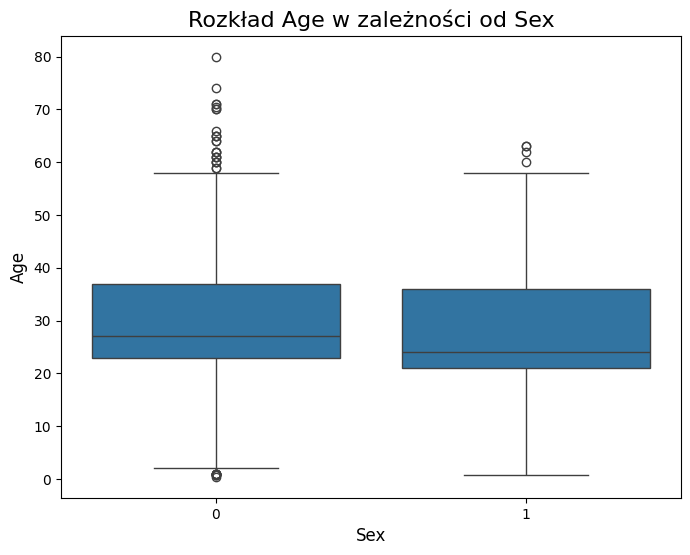

In [103]:
grouped_boxplot(titanic_df, 'Sex', 'Age')

Wykres pokazuje ilość starych i zapewnie bogatych mężczyzn(0) za przedziałami wykresu.

Wszystkie najważniejsze dane przedstawione są w sposób kategoryczny (np płec,klasa,czy przetrwał) lub dyskretne (ilosc dzieci/rodziców) i liepiej są przedstawione innymi typami wykresów, więc szukanie odchyleń w reszcie kategorii jest neistotne dla predykcji przetrwania.

Z analizy wynika, że:

*   Największy wpływ ma klasa/cena biletu i płeć
*   Wiek ma niską korelacje z przetrwaniem
*   Mężczyźni z rodziną mieli większe szanse na przetrwanie niż tacy bez rodziny
*   Najwięcej osób przeżylo z Cherbourgu


